In [145]:
# Import necessary libraries
import matplotlib.pyplot as plt
import numpy as np
import sympy as sp
from scipy.stats import expon
from scipy.stats import uniform
from scipy.optimize import root
from scipy.optimize import minimize
from scipy.optimize import least_squares

We start off by defining our patients' utility function standalone, to be used in the rest of the code.
Note: Unlike in the paper, we use the letter 'k' rather than a greek 'κ' for ease of coding. We write out 'gamma' in the code itself, though in the comments we'll sometimes make use of 'γ' for spacing constraints.

In [528]:
def utility(ki,gammai,kj,Vj,t):
    """
    Computes the J x I matrix of uij's, patient's i utility from patient j if a visit takes place

    Arguments:
        ki: 1 x I vector of patients' "medical necesity", κ_i parameter.
        gammai: 1 x I vector of patients' "taste for certificates", γ_i parameter.
        kj: J x 1 vector of doctors' chosen threshold, κ_j parameter.
        Vj: J x 1 vector of doctors' "service quality", V_j parameter.
        t: parametrized cost of visit.
    """

    # Reshaping parameters to ensure proper broadcasting
    ki = np.array(ki).reshape((1,-1))             # 1 x I
    gammai = np.array(gammai).reshape((1,-1))     # 1 x I
    kj = np.array(kj).reshape((-1,1))             # J x 1
    Vj = np.array(Vj).reshape((-1,1))             # J x 1

    return Vj * ki - t + np.where(ki >= kj, gammai, 0)
                    # This way γ_i is summed if patient i's κ_i is above doctor j's threshold κ_j.

We will define search methods as classes, where their main attributes will be the I x J matrix of patients' strategies --containing each s_ij, i.e. the probability that patient i will visit doctor j--, and the I x J matrix of each d s_ij / d κ_j, i.e. the derivative of s_ij over doctor j's threshold κ_j.

In [505]:
def LogitSearch_derivative(n, J = 3):
    # nth derivative
    # J-sized vector (I go with 3 by default)

    # Define prerequisite symbols
    k = sp.Symbol('k')
    λ = sp.Symbol('λ')
    U = sp.Function('λ')(k)

    # Collection of Vj's and U(i)j's
    V_symbols = sp.symbols(f'V1:{J+1}')
    U_functions = [sp.Function(f'U{j+1}')(k) for j in range(J)]

    # For simplicity we forego the free disposal requirement
    alpha_function = sp.exp(λ*U)

    # We recreate the alpha(i)j matrix
    alpha_matrix = sp.Matrix([alpha_function.subs(U,U_functions[j]) for j in range(J)])
    alpha_total = sum(alpha_matrix)
    # We recreate the Si vector of patient i's strategies over j
    # By dividing the alpha matrix by its total
    Si = alpha_matrix / alpha_total

    # We take the first component as an example for the rest
    example = sp.simplify(
        sp.diff(Si,k,n).subs(
        (sp.diff(U_functions[j],k),V_symbols[j]) for j in range(J)
        ).subs(         # We impose that dUj/dk = Vj
            (sp.diff(V_symbols[j],k),0) for j in range(J)
            )[0]        # We impose that dVj/dk = 0, since it's a scalar
    )

    return example

In [431]:
LogitSearch_derivative(2)

λ*(V1*(exp(λ*U1(k)) + exp(λ*U2(k)) + exp(λ*U3(k))) - V1*exp(λ*U1(k)) - V2*exp(λ*U2(k)) - V3*exp(λ*U3(k)))*exp(λ*U1(k))/(exp(λ*U1(k)) + exp(λ*U2(k)) + exp(λ*U3(k)))**2

In [428]:
def X_derivative(n):
    # Takes the (n + 1)th derivative, because n = 0 is already dX/dk_j 

    # Define prerequisite symbols
    k = sp.Symbol('k')
    gamma = sp.Symbol('gamma')
    s = sp.Function('s')(k,gamma)
    g = sp.Function('g')(gamma)
    f = sp.Function('f')(k)

    # We set up 'int s(k_j,gamma) dG(gamma) f(k_j)'
    integrand = s*g
    integral = sp.integrate(integrand,gamma)
    expression = integral*f
    
    return sp.diff(expression,k,n)

In [562]:
X_derivative(1)

f(k)*Integral(g(gamma)*Derivative(s(k, gamma), k), gamma) + Derivative(f(k), k)*Integral(g(gamma)*s(k, gamma), gamma)

In [557]:
class LogitSearch:

    def __init__(self, ki,  # 1 x I vector of patients' "medical necesity", κ_i parameter.
                    gammai, # 1 x I vector of patients' "taste for certificates", γ_i parameter.
                    kj,     # J x 1 vector of doctors' chosen threshold, κ_j parameter.
                    Vj,     # J x 1 vector of doctors' "service quality", V_j parameter.
                    t,      # Scalar. Parametrized cost of visit.
                    λ):     # Scalar. Logit shape parameter.
    
        # Save parameters
        self.ki, self.gammai, self.kj, self.Vj, self.t, self.λ = ki, gammai, kj, Vj, t, λ

    def U(self):
        """
        Computes the J x I matrix of uij's, patient's i utility from patient j if a visit takes place.
        See definition above.
        """

        # Unpack parameters
        ki, gammai, kj, Vj, t = self.ki, self.gammai, self.kj, self.Vj, self.t

        return utility(ki,gammai,kj,Vj,t)
    
    def alpha_matrix(self):
        """
        Intermediate matrix used to compute S matrix of patients' sij's.
        alpha_ij equals e^(λ*uij) if uij > 0, else 0 (free disposal requirement)
        """

        λ = self.λ  # scalar
        U = self.U()  # J x I matrix of uij's

        return np.where(U > 0, np.exp(λ*U), 0)
    
    def S(self):
        """
        J x I matrix 'S' of patients' strategy vectors S_i, where each component sij stands for
        the probability that patient i visits doctor j.

        (Implicit) arguments:
            ki: 1 x I vector of patients' "medical necesity", κ_i parameter.
            gammai: 1 x I vector of patients' "taste for certificates", γ_i parameter.
            kj: J x 1 vector of doctors' chosen threshold, κ_j parameter.
            Vj: J x 1 vector of doctors' "service quality", V_j parameter.
            t: Scalar. Parametrized cost of visit.
            λ: Scalar. Logit shape parameter.

        Returns:
            s_ij  =  alpha_ij / Σ_j=1^J (alpha_ij)       if      Σ_j=1^J (alpha_ij) > 0
                  =  0                                   ~
                where
            alpha_ij  =  e^(λ*uij)        if      uij > 0
                      =  0                 ~

        Output form:
            s_{i=1,j=1}   s_{i=2,j=1}   ...   s_{i=I,j=1}
            s_{i=1,j=2}   ...                   ...
            # ...                               ...
            s_{i=1,j=J}   ...           ...   s_{i=I,j=J}

        Note:
            It's set up to handle the posibility that no doctors give a certain patient i positive
            utility, in which case he visits none of them -- i.e. S_i = vector(0).
            In all other cases the probability that i visits "some" doctor equals 1.
        """

        # alpha_matrix is a J x I matrix where alpha_ij equals e^(λ*uij) if uij > 0, else 0
        alpha_matrix = self.alpha_matrix()
        # alphai_total outputs the column-wise sum of alpha_ij's, i.e. the total by patient
        alphai_total = np.sum(alpha_matrix, axis = 0)

        with np.errstate(divide='ignore', invalid='ignore'):
            # To avoid pesky division by zero warning      
            return np.where(alphai_total != 0, alpha_matrix/alphai_total, 0)
        
    def dS(self):
        """
        J x I matrix 'S' of the derivative of each patient's s_ij over the respective patient i's
        medical necesity κ_i, i.e. d s_ij / s κ_i.

        Returns:
            a_ij = λ Vj e^(λuij) (Σ_{j=1 to J} e^(λuij)) - e^(λuij) (Σ_{j=1 to J} λ Vj e^(λuij)) 
            b_ij = (Σ_{j=1 to J} e^(λuij))^2 
            d s_ij / s κ_i = a_ij / b_ij

        Output form:
            d s_{i=1,j=1}   d s_{i=2,j=1}   ...   d s_{i=I,j=1}
              d κ_{i=1}       d κ_{i=2}             d κ_{i=I}
            
            d s_{i=1,j=2}       ...                   ...
              d κ_{i=1}
            
            # ...                                     ...

            d s_{i=1,j=J}       ...         ...   d s_{i=I,j=J}
              d κ_{i=1}                             d κ_{i=I}
        """

        alpha_matrix  = self.alpha_matrix()  # J x I matrix of uij's, alpha_ij's resp.
        Vj = self.Vj    # J x 1 vector of physicians' quality Vj
        λ = self.λ  # Scalar. Logit shape parameter.
        Vj = Vj.reshape(-1,1)
        # alphai_total outputs the column-wise sum of alpha_ij's, i.e. the total by patient
        alphai_total = np.sum(alpha_matrix, axis = 0)
        result = np.divide(
            λ*Vj*alpha_matrix*alphai_total 
            - alpha_matrix*np.sum(λ*Vj*alpha_matrix, axis = 0),
            alphai_total**2
            )
        
        return np.where(alphai_total != 0, result, 0)
    
    def d2S(self):
        """
        J x I matrix 'S' of the second derivative of each patient's s_ij over the respective patient i's
        medical necesity κ_i, i.e. d2 s_ij / s κ_i.

        Returns:
            Check out the LogitSearch_derivative() function with n = 2 to look at the syntax.

        Output form:
            d2 s_{i=1,j=1}   d2 s_{i=2,j=1}   ...   d2 s_{i=I,j=1}
              d κ_{i=1}        d κ_{i=2}              d κ_{i=I}
            
            d2 s_{i=1,j=2}       ...                   ...
              d κ_{i=1}
            
            # ...                                     ...

            d2 s_{i=1,j=J}       ...         ...   d2 s_{i=I,j=J}
              d κ_{i=1}                              d κ_{i=I}
        """

        alpha_matrix = self.alpha_matrix()  # J x I matrix of uij's, alpha_ij's resp.
        Vj = self.Vj    # J x 1 vector of physicians' quality Vj
        λ = self.λ  # Scalar. Logit shape parameter.
        Vj = Vj.reshape(-1,1)

        sum_eU = np.sum(alpha_matrix, axis = 0)         # Σ e^(λU) (previously alphai_total)
        sum_VeU = np.sum(Vj*alpha_matrix, axis = 0)     # Σ Ve^(λU)
        sum_V2eU = np.sum((Vj**2)*alpha_matrix, axis = 0)    # Σ V^2 e^(λU)

        result = np.divide(
            (λ**2)*alpha_matrix*(
                (Vj**2)*(sum_eU**2) + 2*(sum_VeU**2)
                - sum_eU*(sum_V2eU + 2*Vj*sum_VeU)
            ),
            sum_eU**3
        )

        return result

    def d3S(self):
        """
        J x I matrix 'S' of the third derivative of each patient's s_ij over the respective
        patient i's medical necesity κ_i, i.e. d3 s_ij / s κ_i.

        Returns:
            Check out the LogitSearch_derivative() function with n = 2 to look at the syntax.

        Output form:
            d3 s_{i=1,j=1}   d3 s_{i=2,j=1}   ...   d3 s_{i=I,j=1}
              d κ_{i=1}        d κ_{i=2}              d κ_{i=I}
            
            d3 s_{i=1,j=2}       ...                   ...
              d κ_{i=1}
            
            # ...                                     ...

            d3 s_{i=1,j=J}       ...         ...   d3 s_{i=I,j=J}
              d κ_{i=1}                              d κ_{i=I}
        """

        alpha_matrix = self.alpha_matrix()  # J x I matrix of uij's, alpha_ij's resp.
        Vj = self.Vj    # J x 1 vector of physicians' quality Vj
        λ = self.λ  # Scalar. Logit shape parameter.
        Vj = Vj.reshape(-1,1)

        sum_eU = np.sum(alpha_matrix, axis = 0)         # Σ e^(λU) (previously alphai_total)
        sum_VeU = np.sum(Vj*alpha_matrix, axis = 0)     # Σ Ve^(λU)
        sum_V2eU = np.sum((Vj**2)*alpha_matrix, axis = 0)    # Σ V^2 e^(λU)
        sum_V3eU = np.sum((Vj**3)*alpha_matrix, axis = 0)    # Σ V^3 e^(λU)

        result = np.divide(
            (λ**3)*alpha_matrix*(
                (Vj**3)*(sum_eU**3) - 6*(sum_VeU**3)
                + 6*sum_eU*sum_VeU*(sum_V2eU + Vj*sum_VeU)
                - (sum_eU**2)*(sum_V3eU + 3*(Vj**2)*sum_VeU + 3*Vj*sum_V2eU)
            ),
            sum_eU**4
        )

        return result


In [518]:
# Number of doctors and patients
I = 10
J = 5

b = 5

F = expon(scale=1/b)

##CHECK THIS OUT
#from scipy.stats import rv_continuous


#class piecewise_dist(rv_continuous):
    #def _pdf(self, x):
        # Define PDF piecewise
        #if 1 < x < 2:
            #return np.log(x) / self.norm_const
        #else:
            #return 0
    

# Create an instance of the custom distribution
#custom_dist = piecewise_dist(name='piecewise_dist')
#custom_dist.cdf(3)



G = uniform(scale = 1)
H = uniform(scale = 2)

f = lambda x: F.pdf(x)
g = lambda x: G.pdf(x)

rng = np.random.RandomState(seed=123)         # Set up number generator using seed
V = H.rvs(size=J, random_state=rng)     # Create J-size vector of Vj values using H

r = 1.5
p = 1/100

R = lambda x: r * x
P = lambda x: p/2 * x**2

dR = lambda x: r + x - x
dP = lambda x: p * x

d2R = lambda x: 0 + x - x
d2P = lambda x: p + x - x

df = lambda x: -b*f(x)

k0 = np.zeros(J)



λ = 5
t = 0.1

rng = np.random.RandomState(123)
ki = F.rvs(size=I, random_state=rng)   # Sample of patients out of distribution
gammai = G.rvs(size=I, random_state=rng)

Vj = np.sort(V)    # Reshaping doctor parameters for proper broadcasting
kj = k0

(ki)

array([0.23845443, 0.0674135 , 0.05145682, 0.16028674, 0.25421419,
       0.11001951, 0.79019641, 0.23092845, 0.13114404, 0.09955474])

The function 'sij' gives us each patient's Si vector of strategies, and if broadcast correctly it can output all patients' strategies in a single array (given numerable patients in a MC simulation), where each column is each patient’s Si, each row could be added up to a doctor's Qi.

We keep it as a callable function for cases where we want the sij of a particular set of patient x doctor parameters, namely when calculating the derivative of our FOC.

Note on how we treat 'functions' inside our equilibrium class:

We will define the distributions F, G and H as a classes such that its attributes mimick those of scipy distributions, such that one may simply input a scipy distribution instead of making a class from scratch (like we will).

Our physicians' R( ) and P( ) functions will be defined such that they'll take on the same shape for each one, and either a single scalar or a 1 x J vector may be inputed for the parameter slots, and then the actual argument will be doctors' Qj and Xj respectively. We will also define R( ) and P( ) as classes where their evaluation is an attribute, other atttributes including first and second derivatives (in the manner of our search classes), but for flexibility we may initially input an actual function instead of a class as R( ) or P( ), where later attributes requiring derivatives will need them to be manually inputed.

In [614]:
####################################################################################################

class SearchEq:
    
    def __init__(self,  I,  # Number of patients in the whole market
                        F,  # Distribution of κi
                        G,  # Distribution of γi
                        t,  # Cost of visit
                        λ,  # Logit parameter
                        R,  # Revenue function Rj
                        P,  # Punishment function Pj
                        V,  # Given vector of Vj
                        sij): # Search function
       
        self.I, self.F, self.G, self.t, self.λ = I, F, G, t, λ      # Save parameters
        self.R, self.P, self.V, self.sij = R, P, V, sij         

    
    def S(self, k0, s=123):
        """MC simulation of the set of patient strategies out of a given set κ0 of doctor thresholds, seed s"""

        I, F, G, t, λ, V, sij = self.I, self.F, self.G, self.t, self.λ, self.V, self.sij    # Unpack parameters
        
        rng = np.random.RandomState(s)
        ki = F.rvs(size=I, random_state=rng).reshape((1,-1))    # Sample of patients out of distribution
        gammai = G.rvs(size=I, random_state=rng).reshape((1,-1))
        
        Vj = V
        kj = k0

        return sij(ki,gammai,kj,Vj,t,λ).S()

    def Q(self, k0, s=123):
        """Vector of expected patient demand by each doctor j out of an MC simulation of Si"""

        S = self.S(k0, s)

        return np.sum(S, axis = 1)
    
    def X(self, k0, s=123):
        """Vector of expected certificates granted by each doctor j out of an MC simulation of Si"""

        S = self.Si(k0, s)
        F, I = self.F, self.I
        rng = np.random.RandomState(s)
        ki = F.rvs(size=I, random_state=rng).reshape((1,-1))
        # We recreate the ki vector with the same seed, so it's the same
        
        ki_greater = np.array(ki.reshape((1,-1)) >= k0.reshape((-1,1))).astype(int) 

        return np.sum(S*ki_greater, axis = 1)
    
    def aux_func(self, k0, func, method = 'at'):
        """
        Vector of int func(k0,gamma) dG(gamma). It's a very useful middle step when defining
        the various n-derivatives of Q and X over k.

        Arguments:
            k0: J x 1 vector of doctors' chosen threshold, κ_j parameter.
            func: Search class function which will be integrated over gamma taking the k-values
                of k0. Possible values: 'S', 'dS', 'd2S', 'd3S'.
            method: Either 'at' (default) or 'over'. 'at' evaluates the integral when k_i is
                right at the threshold, 'over' when the threshold is a bit over k_i.

        Use:
            dX/dk will make use of just the 'at' method, whereas dQ/dk uses both, as it considers
            Si before and after being above the threshold, namely: func('over') - func('at').
                   
        Output form:
            ∫_γ s_func(k1,γ)_{j=1} dG(γ)   ...   ∫_γ s_func(kJ,γ)_{j=1} dG(γ)
            # ...                                 ...
            ∫_γ s_func(k1,γ)_{j=J} dG(γ)   ...   ∫_γ s_func(kJ,γ)_{j=J} dG(γ)
        """

        # We will use this function both for s_func = sij as well as its derivatives
        G, t, λ, V, sij = self.G, self.t, self.λ, self.V, self.sij    # Unpack primitives
        g = lambda x: G.pdf(x)      # Using the pdf for the integral


        if method == 'over':    #Integral where k_j is marginally higher than k_i
                s_gamma = lambda x: getattr(sij(k0,x,k0+1e-8,V,t,λ), func)()   
        elif method == 'at':    #Integral where k_j is equal to than k_i
                s_gamma = lambda x: getattr(sij(k0,x,k0,V,t,λ), func)() 
        else:
            raise ValueError("Invalid method selected. Please choose 'at' or 'over'.")
        
        # We restrict possible functions to those with defined modules in our search class
        if func not in ['S', 'dS', 'd2S', 'd3S']:
            raise ValueError("Invalid function selected. Please choose 'S', 'dS', 'd2S' or 'd3S'.")
            
        # Evaluate func at each doctor's κj, then take the diagonal, taking doctor j's func for his own kj
        # This is a lambda function for a given value of γ
        # Output form:
        # s_func(k1,γ)_j=1   s_func(k2,γ)_j=1     ...     s_func(kJ,γ)_j=1
        # s_func(k1,γ)_j=2   ...                          ...
        # ...
        # s_func(kJ,γ)_j=J   ...                          s_func(kJ,γ)_j=J

        gamma_integrand = lambda x: s_gamma(x) * g(x) # sij(γ) g(γ)

        n = 101
        x = np.linspace(G.ppf(0),G.ppf(1),n) # n-sized linspace across the domain of G

        results = []

        # Loop that evaluates sij(γ) g(γ) for 101 values of γ
        for i in x:
                result = gamma_integrand(i)
                results.append(result)

        results = np.array(results)

        mc_integral = np.sum(results, axis = 0)/n
        # By summing column wise divided by n we get a monte-carlo approximation of an integral

        # As said before, in the 'at' method we multiply the diagonal by (-1).
        if method == 'at':
            J = len(k0)
            # Create a matrix of ones
            signs_matrix = np.ones((J, J))
            # Set the diagonal elements to -1
            np.fill_diagonal(signs_matrix, -1)
            # Replace integral matrix
            mc_integral = mc_integral*signs_matrix

        return mc_integral
    
    def dQ(self, k0):
        """Computed the jacobian of Q over the vector of κ_j's (physician strategies)"""
         
        F = self.F     # We retrieve our f pdf
        f = lambda x: F.pdf(x)
         
        # We compute both integrals, left and right respectively
        int_over = self.aux_func(k0, func = 'S', method = 'over')
        int_at = self.aux_func(k0, func = 'S', method = 'at')

        # We take only the diagonal of int_at with a dot-product with the identity matrix.
        # We do this because the cross derivatives will otherwise cancel each other out.
        J = len(k0)
        multiplier = np.eye(J)

        k0 = k0.reshape(-1,1)   # Reshaping for broadcasting

        return (int_over + multiplier*int_at)*f(k0)
    
    def dX(self, k0):
        """Computed the jacobian of X over the vector of κ_j's (physician strategies)"""
         
        F = self.F     # We retrieve our f pdf
        f = lambda x: F.pdf(x)

        # We only need the 'at' integral
        int_at = self.aux_func(k0, func = 'S', method = 'at')

        # For the cross derivatives, a small raise in κ_l only affects κ_j in terms of X
        # (certificates granted) if κ_l was above κ_j, meaning j's new expected clientele
        # will get sick leave. For this reason, we compute the following matrix of 1s and 0s
        kj_larger = (k0[:, None] <= k0[None, :]).astype(int)
        # Output form:
        # κ_1 ≤ κ_1     κ_1 ≤ κ_2   ...     κ_1 ≤ κ_J
        # κ_2 ≤ κ_2     ...                 ...
        # ...
        # κ_J ≤ κ_1                         κ_J ≤ κ_J
        # This way the diagonal is also preserved.

        k0 = k0.reshape(-1,1)   # Reshaping for broadcasting

        return kj_larger * int_at * f(k0)

    
    def FOC(self, k0, dR, dP, s=123):
        """Out of the previous MC results, it outputs the value of evaluated FOC"""

        Q = self.Qi(k0, s)
        X = self.Xi(k0, s)
        sij = self.sij
        dQ_dk = self.aux_func(sij, k0)

        return (dR(Q) - dP(X))*dQ_dk
    
    def simple_FOC(self, k0, dR, dP, s=123):
        """Out of the previous MC results, it outputs the value of evaluated FOC"""

        I = self.I

        Q = self.Qi(k0, s)
        X = self.Xi(k0, s)

        return (dR(Q) - dP(X))
    
    def dFOC_dk(self, k0, dR, dP, d2R, d2P, ds, df, s=123): #For now, we manually input the derivatives and second derivatives of interest

        Q = self.Qi(k0, s)
        X = self.Xi(k0, s)
        sij = self.sij
        dQ_dk = self.aux_func(sij, k0)
        d2Q_dk = self.aux_func(ds, k0) + self.aux_func(sij, k0) * df(Q) # Double derivative of Q over κ

        return (dR(Q) - dP(X))*d2Q_dk + (d2R(Q) - d2P(X))*dQ_dk
        





In [119]:
# Number of doctors and patients
I = 10000
J = 50

b = 5

F = expon(scale=1/b)
G = uniform(scale = 1)
H = uniform(scale = 10)

f = lambda x: F.pdf(x)
g = lambda x: G.pdf(x)

rng = np.random.RandomState(seed=123)         # Set up number generator using seed
V = H.rvs(size=J, random_state=rng)     # Create J-size vector of Vj values using H

r = 1.5
p = 1/100

R = lambda x: r * x
P = lambda x: p/2 * x**2

dR = lambda x: r + x - x
dP = lambda x: p * x

d2R = lambda x: 0 + x - x
d2P = lambda x: p + x - x

df = lambda x: -b*f(x)

k0 = np.ones(J)*0.5

λ = 1
t = 0.1


In [615]:
LogitModel = SearchEq(I, F, G, t, λ, R, P, Vj, LogitSearch)
a = LogitModel.dQ(k0)

LogitModel.dX(k0)


array([[-1.96607103,  0.89172828,  0.29704244,  0.04507232,  0.01099423],
       [ 0.        , -0.39190721,  0.14698263,  0.0266442 ,  0.00731736],
       [ 0.        ,  0.        , -0.20360698,  0.08177527,  0.03816824],
       [ 0.        ,  0.        ,  0.        , -0.05827716,  0.03636286],
       [ 0.        ,  0.        ,  0.        ,  0.        , -0.01683644]])

In [573]:
k0 = np.array([0.1,0.3,0.5,0.8,1])

if method = 'over':
        s_gamma = lambda x: sij(k0,x,k0+1e-8,V,t,λ).func()   
else:
        s_gamma = lambda x: sij(k0,x,k0,V,t,λ).func()
       
# Evaluate func at each doctor's κj, then take the diagonal, taking doctor j's func for his own kj
# This is a lambda function for a given value of γ
# Output form:
# s(k1,γ)_j=1   s(k2,γ)_j=1     ...     s(kJ,γ)_j=1
# s(k1,γ)_j=2   ...                     ...
# ...
# s(kJ,γ)_j=J   ...                     s(kJ,γ)_j=J

gamma_integrand = lambda x: s_gamma(x) * g(x) # sij(γ) g(γ)

n = 101
x = np.linspace(G.ppf(0),G.ppf(1),n) # n-sized linspace across the domain of G

results = []

# Loop that evaluates sij(γ) g(γ) for 101 values of γ
for i in x:
        result = gamma_integrand(i)
        results.append(result)

results = np.array(results)

mc_integral = np.sum(results, axis = 0)/n
# By summing column wise divided by n we get a monte-carlo approximation of an integral

J = len(k0)
# Create a matrix of ones
signs_matrix = np.ones((J, J))
# Set the diagonal elements to -1
np.fill_diagonal(signs_matrix, -1)
# Replace integral matrix
mc_integral = mc_integral*signs_matrix

 #######       return mc_integral * f(k0.reshape(1,-1))

mc_integral

array([[-0.3462418 ,  0.76578315,  0.72388444,  0.77601104,  0.68392978],
       [ 0.        , -0.03033143,  0.09303563,  0.02912299,  0.01129722],
       [ 0.        ,  0.02538912, -0.01028203,  0.01812378,  0.00624436],
       [ 0.29946063,  0.06720252,  0.05207652, -0.0365239 ,  0.16018207],
       [ 0.35429757,  0.11129378,  0.12072138,  0.14021829, -0.13834658]])

In [570]:
mc_integral

array([[-0.78917258,  0.63158672,  0.68045602,  0.63636498,  0.39706902],
       [ 0.        , -0.18442552,  0.08745409,  0.0238822 ,  0.00655883],
       [ 0.        ,  0.02291134, -0.06501867,  0.01486234,  0.00362528],
       [ 0.09657165,  0.06064407,  0.05035066, -0.19924534,  0.09299688],
       [ 0.11425576,  0.10043235,  0.11672056,  0.12564514, -0.49974999]])

In [83]:
rng = np.random.RandomState(123)
ki = F.rvs(size=I, random_state=rng).reshape((1,-1))    # Sample of patients out of distribution
gammai = G.rvs(size=I, random_state=rng).reshape((1,-1))

V =  np.sort(V)
Vj = V.reshape((-1,1))      # Reshaping doctor parameters for proper broadcasting
kj = k0.reshape((-1,1))
Vj = np.sort(Vj)

ki.shape

(1, 10000)

In [104]:
def cartesian_product_stack(k1_vals, k2_vals, J):
    # Create meshgrid for k1_vals and k2_vals
    k1_grid, k2_grid = np.meshgrid(k1_vals, k2_vals, indexing='ij')
    
    # Stack k2_grid J - 1 times along a new axis
    k2_stacked = np.tile(k2_grid[:, :, np.newaxis], (1, 1, J - 1))
    
    # Combine k1_grid and stacked k2_grid along the last axis
    cartesian_grid = np.concatenate((k1_grid[:, :, np.newaxis], k2_stacked), axis=-1)
    
    return cartesian_grid

k1_vals = np.linspace(0,2,100)
k2_vals = np.linspace(0,2,100)

combination = cartesian_product_stack(k1_vals, k2_vals, J)

Qi_combinations = np.apply_along_axis(LogitModel.Qi, axis=-1, arr=combination)
Xi_combinations = np.apply_along_axis(LogitModel.Qi, axis=-1, arr=combination)
FOC_condition = dR(Qi_combinations) - dP(Xi_combinations)
FOC_condition.shape


In [166]:
J = 2
V = H.rvs(size=J, random_state=rng)
LogitModel = SearchEq(I, F, G, t, λ, R, P, V, logit_search)

x = np.linspace(0,2,100)
y = np.linspace(0,2,100)
X, Y = np.meshgrid(x, y)

# Flatten the grids and stack them as 1x2 vectors
XY = np.stack([X.ravel(), Y.ravel()], axis=1)

func2 = lambda x: np.sum(LogitModel.FOC(x, dR, dP))

# Apply the function to each vector
Z = np.apply_along_axis(func2, 1, XY).reshape(X.shape)

# Create the heatmap
plt.figure(figsize=(8, 6))
plt.contourf(X, Y, Z, levels=50, cmap='viridis')
plt.colorbar(label='Function Value')
plt.contour(X, Y, Z, levels=[0], colors='red', linewidths=2)
plt.xlabel('x')
plt.ylabel('y')
plt.title('Heatmap of func([x, y])')
plt.show()

KeyboardInterrupt: 

In [8]:
LogitModel = SearchEq(I, F, G, t, λ, R, P, Vj, logit_search)
f = lambda x: LogitModel.simple_FOC(x, dR, dP)
Df = lambda x: LogitModel.dFOC_dk(x, dR, dP, d2R, d2P, dlogit_search_dk, df)

In [67]:
k_guess = np.zeros(J)    
k, error, Dk, beta = NAG(Df, f, k_guess, tol=1e-7, max_iter=100, alpha = 0.01, beta = 0.99)

/var/folders/d9/f39ks_q941961hvlpvd2zymc0000gn/T/ipykernel_43707/2999820999.py:33: RuntimeWarning: invalid value encountered in divide
  result = np.divide(


Convergence not acheived, max iterations


In [68]:
k_newish = -0.05*k
kia, error, Dk, beta = NAG(Df, f, k_newish, tol=1e-7, max_iter=100, alpha = 0.01, beta = 0.99)
kia

/var/folders/d9/f39ks_q941961hvlpvd2zymc0000gn/T/ipykernel_43707/2999820999.py:33: RuntimeWarning: invalid value encountered in divide
  result = np.divide(


array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [48]:
g = lambda x: np.sum(x)

def hessp(x, p):
    epsilon = 1e-5  # Small perturbation for finite differences
    grad = Df(x)
    return (Df(x + epsilon * p) - grad) / epsilon

v = minimize(
    g, k, method='trust-ncg', jac=Df, hessp=hessp,
    options={
        'verbose': 2,
        'xtol': 1e-20,  # Set xtol to a very small value so it doesn't trigger termination
        'gtol': 1e-6,   # Stop based on the gradient tolerance
        'maxiter': 10  # Allow more iterations
    }
)

/var/folders/d9/f39ks_q941961hvlpvd2zymc0000gn/T/ipykernel_43707/1157539426.py:19: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


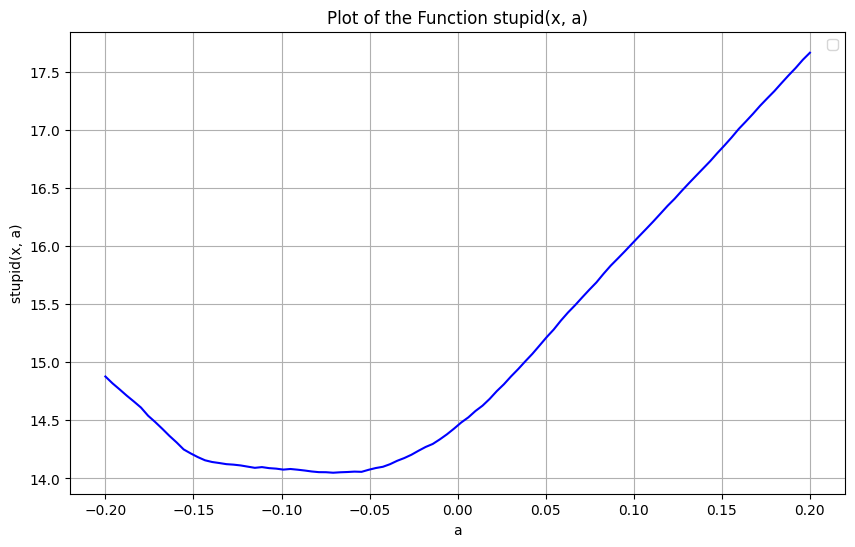

In [64]:
def stupid(x,a):
    x_new = (1+a)*x
    FOC = f(x_new)
    FOC_abs = np.abs(FOC)
    return np.sum(FOC_abs)

# Define a range of values for a
a_values = np.linspace(-0.2, 0.2, 100)  # Adjust range and number of points as needed

# Compute the function values for each a
y_values = np.array([stupid(k, a) for a in a_values])

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(a_values, y_values, color='blue')
plt.xlabel('a')
plt.ylabel('stupid(x, a)')
plt.title('Plot of the Function stupid(x, a)')
plt.legend()
plt.grid(True)
plt.show()

In [52]:
k - v.x

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [17]:
def compute_hessian(f, k, h=1e-4):
    n = len(k)
    hessian = np.zeros((n, n))  # Initialize an n x n matrix for the Hessian

    for i in range(n):
        k_plus_h = np.copy(k)  # Copy the original k
        k_plus_h[i] += h  # Perturb the i-th element of k

        # Compute the second derivative (finite difference approximation)
        second_derivative = (f(k_plus_h) - f(k)) / h
        hessian[i, :] = second_derivative
    return hessian

def newton_method(Df, k_0, tol=1e-7, max_iter=100, h=1e-4):

    k = k_0
    for i in range(max_iter):
        gradient = Df(k)  # Evaluate the gradient
        hessian = compute_hessian(Df, k, h=h)  # Evaluate the Hessian matrix
        
        # Check if the Hessian is invertible
        if np.linalg.cond(hessian) > 1e12:
            print("Hessian is nearly singular.")
            break
        
        # Newton's update step
        delta_k = np.linalg.solve(hessian, gradient)  # Equivalent to H^-1 * grad
        k_new = k - delta_k
        
        # Check for convergence
        if np.linalg.norm(delta_k) < tol:
            print(f"Convergence reached in {i+1} iterations.")
            return k_new
        
        k = k_new
        k[k<0] = 0

    print(f"Maximum iterations ({max_iter}) reached without convergence.")
    return k

In [19]:
compute_hessian(f, k, h=1e-4).shape

(50, 50)

In [1072]:
f(k_newton)

array([ 0.08592965,  0.03082867, -0.00828313, -0.10436103, -0.11611035,
       -0.1930107 , -0.19537101, -0.23559984, -0.30615324, -0.32142829,
       -0.36223428, -0.37245747, -0.3843971 , -0.43159816, -0.48003863,
       -0.56163982, -0.57632885, -0.02049767, -0.04146855, -0.01625463,
       -0.02061216, -0.2505763 , -0.03695426, -0.02114358, -0.02374466,
       -0.02559759, -0.02791532, -0.02481907, -0.13764299,  1.49349729,
       -0.03538633,  1.49905038, -0.02916782, -0.02529223, -0.02504878,
       -0.03719397, -0.01813942, -0.02556895,  1.49821245,  1.09947455,
        1.49996119, -0.00723399,  1.49653988, -0.00150912,  1.5       ,
        1.5       ,  1.5       ,  1.5       ,  1.5       ,  1.5       ])

In [1059]:
k_plus_h = np.copy(k)  # Copy the original k
k_plus_h[i] += h  # Perturb the i-th element of k

    # Compute the second derivative (finite difference approximation)
second_derivative = Dk(k) 

TypeError: 'numpy.ndarray' object is not callable

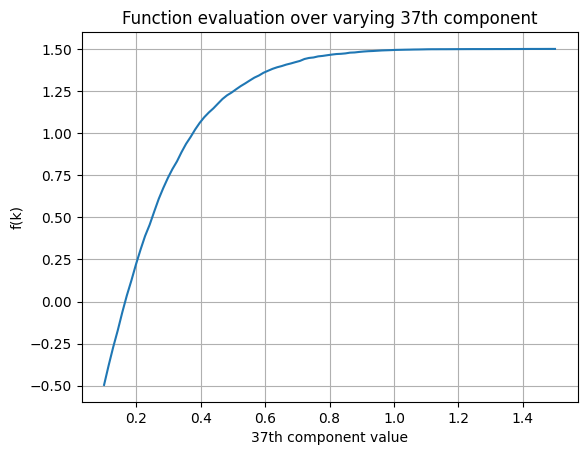

[np.float64(-0.49492657055904954),
 np.float64(-0.3795919571640791),
 np.float64(-0.2709044366983806),
 np.float64(-0.1716615640281265),
 np.float64(-0.06383467128998066),
 np.float64(0.03617366046429682),
 np.float64(0.1252386576918345),
 np.float64(0.2203761613720181),
 np.float64(0.307638548244199),
 np.float64(0.38895094832007615),
 np.float64(0.45543897863188),
 np.float64(0.5334328038881432),
 np.float64(0.6093095639987297),
 np.float64(0.6740322988111316),
 np.float64(0.7333949001108727),
 np.float64(0.7862175862166774),
 np.float64(0.8319207720916049),
 np.float64(0.8866951661766143),
 np.float64(0.9361957915764358),
 np.float64(0.9771183425331891),
 np.float64(1.0216365928169222),
 np.float64(1.0610039532706157),
 np.float64(1.0945110517937182),
 np.float64(1.1225186374798708),
 np.float64(1.1469609278625756),
 np.float64(1.1750168536927426),
 np.float64(1.2026749249757884),
 np.float64(1.2243762958834399),
 np.float64(1.2409317043317438),
 np.float64(1.260422787408315),
 np.f

In [1019]:
def graph_component_37(f, k_original, i, start, stop, num_points=100):
    """
    Function to graph the effect of changing the 37th component of a vector on the output of a function.

    Parameters:
    - f: The function to evaluate.
    - k_original: The original input vector (must be at least 38 elements long).
    - start: The start value for the 37th component.
    - stop: The stop value for the 37th component.
    - num_points: The number of points in the linspace (default is 100).

    Returns:
    - A plot of f(k) as the 37th component of k changes.
    """
    if len(k_original) < i + 1:
        raise ValueError("Input vector must be at least 38 elements long.")
    
    # Generate a linspace for the 37th component
    linspace_values = np.linspace(start, stop, num_points)
    
    # Keep the original vector unchanged for components other than the 37th
    k_fixed = np.copy(k_original)
    
    # Store the results of the function evaluations
    results = []

    # Evaluate the function over the linspace
    for value in linspace_values:
        k_fixed[i] = value  # Update the 37th component (index 36 for 0-based indexing)
        result = f(k_fixed)[i] # Evaluate the function
        results.append(result)

    # Plot the results
    plt.plot(linspace_values, results)
    plt.title("Function evaluation over varying 37th component")
    plt.xlabel("37th component value")
    plt.ylabel("f(k)")
    plt.grid(True)
    plt.show()
    
    return results


graph_component_37(f, k_original, 37, 0.1, 1.5, num_points=100)

In [277]:
def newton(f, Df, x_0, tol=1e-7, max_iter=100_000):     # As seen in QuantEcon
    x = x_0

    # Implement the zero-finding formula
    def q(x):
        Df_x = Df(x)  # Compute Df(x) once to avoid redundant calculations
        return np.where(Df_x == 0, 0, x - f(x) / Df_x)

    error = tol + 1
    n = 0
    while np.any(error > tol):
        n += 1
        if(n > max_iter):
            print("Convergence not acheived, max iterations")
            break
        y = q(x)
        error = np.abs(x - y)
        
        x = y
        x[x<0] = 0
        error = np.where(x == 0, 0, error)
        # Corner solutions at 0 not considered in convergence condition
        if all(x == 0):
            break
    return x, error, Df(x)

In [12]:
def NAG(Df, f, x_0, tol=1e-7, max_iter=100_000, alpha = 0.001, beta = 0.99):
    x = x_0
    v = np.zeros(J)

    # Implement the zero-finding formula
    def q(x, v, alpha, beta):
        arg = x - beta*v
        v_new = beta*v + alpha*Df(arg)
        x_new = x - v_new
        return x_new, v_new

    error = tol + 1
    n = 0
    while np.any(error > tol):
        n += 1
        if(n > max_iter):
            print("Convergence not acheived, max iterations")
            break
        y, v_new = q(x, v, alpha, beta)
        error = np.abs(f(y))
        
        x = y
        v = v_new
        x[x<0] = 0
        error = np.where(x == 0, 0, error)
        # Corner solutions at 0 not considered in convergence condition
        if all(x == 0):
            break
    return x, error, Df(x), beta

In [1027]:
def newNAG(Df, f, x_0, tol=1e-7, max_iter=100_000, alpha = 0.001, beta = 0.99, decay=0.01):
    x = x_0
    v = np.zeros(J)

    # Implement the zero-finding formula
    def q(x, v, alpha, beta):
        arg = x - beta*v
        v_new = beta*v + alpha*Df(arg)
        x_new = x - v_new
        return x_new, v_new

    error = tol + 1
    n = 0
    while np.any(error > tol):
        n += 1
        alpha = alpha / (1 + n*decay)
        beta = beta / (1 + n*decay)
        if(n > max_iter):
            print("Convergence not acheived, max iterations")
            break
        y, v_new = q(x, v, alpha, beta)
        error = np.abs(f(y))
        
        x = y
        v = v_new
        x[x<0] = 0
        error = np.where(x == 0, 0, error)
        # Corner solutions at 0 not considered in convergence condition
        if all(x == 0):
            break
    return x, error, Df(x), beta

In [1]:
def GD(Df, x_0, tol=1e-7, max_iter=100_000, alpha=0.01, beta=0.9):
    """
    Gradient Descent with Momentum and Adaptive Learning Rate Handling.
    """
    x = x_0
    v = np.zeros_like(x)
    
    # Update rule with momentum and adaptive learning rate
    def q(x, v, alpha, beta):
        v_new = beta * v + (1 - beta) * Df(x)
        x_new = x - alpha * v_new
        return x_new, v_new

    error = tol + 1
    n = 0
    
    while np.any(error > tol):
        n += 1
        if n > max_iter:
            print("Convergence not achieved, max iterations reached")
            break

        # Perform the gradient descent update
        y, v_new = q(x, v, alpha, beta)
        
        # Update x and v
        x = y
        v = v_new
        
        # Handle corner solutions (e.g., keeping x non-negative)
        x[x < 0] = 0
        error = np.where(x == 0, 0, error)
        
        if np.all(x == 0):
            break
    
    return x, error, Df(x)

In [190]:
def by_root(k_0,i,f):
    
    def subs(x,k_0,i,f):
        k_0[i] = x[0]
        return f(k_0)[i]
    
    guess = k_0[i]
    function = lambda x: subs(x,k_0,i,f)

    return root(function, guess, method='hybr')

def bisect(f, x_0, tol=1e-3, max_iter=100_000):
    x = x_0
    
    error = tol + 1
    n = 0    
    while np.any(error > tol):
        n += 1
        if(n > max_iter):
            print("Convergence not acheived, max iterations")
            break
        
        results = np.zeros_like(x)
        for i, x_i in enumerate(x):
            if x_i > 0:
                result = np.array(by_root(x, i, f).x)
                results[i] = result[0]  # Update xi with the found root
        x = results

        x[x<0] = 0
        error = np.abs(f(x))
        error = np.where(x == 0, 0, error)
        # Corner solutions at 0 not considered in convergence condition
    return x, error, Df(x)

In [1010]:
LogitModel.Qi(np.zeros(J))

array([ 950.74936584,  995.56606892, 1026.29342594, 1104.40989416,
       1113.83785849, 1175.44309396, 1177.46202758, 1209.9791021 ,
       1264.47107605, 1276.51342616, 1307.12602139, 1315.44753239,
       1325.14420488, 1360.54271197, 1394.78817338, 1453.58126334,
       1465.44384284, 1500.41742818, 1518.19747723, 1524.11302268,
       1525.29579634, 1535.27601281, 1541.60576723, 1552.6272642 ,
       1654.54472033, 1659.78856514, 1687.5212487 , 1709.36298055,
       1757.75827404, 1792.14795673, 1792.99148407, 1851.75342801,
       2053.52318989, 2060.5297897 , 2102.61207088, 2130.08296393,
       2143.72414392, 2364.56450902, 2421.31772405, 2540.14851073,
       2556.37160346, 2567.42334199, 2593.34228367, 2644.46248765,
       3464.33976135, 3626.74322876, 3916.21454302, 4577.87709215,
       5178.81003996, 5267.71220027])

In [210]:
# Function to adaptively reduce learning rate as iterations increase
def adaptive_alpha(alpha, decay_rate, iteration):
    return alpha / (1 + decay_rate * iteration)

# Function to reduce momentum near the solution
def adaptive_beta(beta, error, threshold=0.1):
    if error < threshold:
        return beta * 0.9  # Reduce momentum
    return beta

# Function to clip the gradient to avoid large updates
def gradient_clipping(gradient, clip_value=1.0):
    norm = np.linalg.norm(gradient)
    if norm > clip_value:
        return gradient * (clip_value / norm)
    return gradient

# NAG implementation with adaptive alpha, beta, and gradient clipping
def NAG2(Df, f, x_0, tol=1e-7, max_iter=100_000, alpha=0.01, beta=0.9, decay_rate=0.001, clip_value=1.0, threshold=0.01):
    x = np.array(x_0)  # Ensure x is a NumPy array
    v = np.zeros_like(x)  # Initialize momentum vector
    n = 0
    error = np.inf  # Initialize error to start the loop

    while np.linalg.norm(error) > tol:
        n += 1
        if n > max_iter:
            print("Max iterations reached")
            break

        # Update learning rate and momentum adaptively
        alpha = adaptive_alpha(alpha, decay_rate, n)
        beta = adaptive_beta(beta, np.linalg.norm(f(x)), threshold)

        # Compute the gradient and apply clipping
        gradient = Df(x)
        clipped_gradient = gradient_clipping(gradient, clip_value)


        v_new = beta * v + (1 - beta) * clipped_gradient
        x_new = x - alpha * v_new

        # Compute error
        error = np.abs(f(x_new))
        
        # Update variables for next iteration
        x, v = x_new, v_new

        x[x<0] = 0
        error = np.where(x == 0, 0, error)
        
        # Print intermediate error every 100 iterations
        if n % 100 == 0:
            print(f"Iteration {n}, error: {np.linalg.norm(error)}")

    return x, error, Df(x), beta

In [1029]:
k_guess = np.zeros(J)    
k, error, Dk, beta = NAG(Df, f, k_guess, tol=1e-7, max_iter=1000, alpha = 0.01, beta = 0.99)
k


Convergence not acheived, max iterations


array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.02551845, 0.02705973, 0.0275226 ,
       0.02765293, 0.02870436, 0.02927973, 0.03046342, 0.04051723,
       0.04099094, 0.0437351 , 0.04651853, 0.05171759, 0.05569925,
       0.05573529, 0.06313752, 0.08929772, 0.09009525, 0.09613794,
       0.10004211, 0.10206899, 0.1336918 , 0.14092338, 0.15729605,
       0.15980151, 0.16160153, 0.16538248, 0.17249563, 0.28885378,
       1.95740036, 3.42985216, 5.43754722, 7.00427274, 7.24031166])

In [1037]:
f(k)

array([ 1.15907775e-01,  6.28059965e-02,  2.52377005e-02, -6.64413818e-02,
       -7.76232026e-02, -1.50713660e-01, -1.52943882e-01, -1.91057417e-01,
       -2.57926882e-01, -2.72374572e-01, -3.11067493e-01, -3.20694552e-01,
       -3.31950251e-01, -3.76680606e-01, -4.22656169e-01, -4.99952052e-01,
       -5.13739868e-01, -1.30903978e-03, -1.41004010e-03, -1.22946065e-03,
       -1.32377974e-03, -1.33539750e-03, -1.19275799e-03, -1.42465950e-03,
       -1.25757025e-03, -1.31936235e-03, -1.39507728e-03, -1.31987442e-03,
       -1.24674310e-03, -1.46231115e-03, -1.36834625e-03, -1.21779116e-03,
       -1.35266832e-03, -1.32990576e-03, -1.41693736e-03, -1.28795439e-03,
       -1.15390676e-03, -1.47299367e-03, -1.32028622e-03, -1.30181017e-03,
       -1.22838049e-03, -1.17302427e-03, -1.37610102e-03, -1.46492312e-03,
       -1.51198005e-03,  1.50000000e+00,  1.50000000e+00,  1.50000000e+00,
        1.50000000e+00,  1.50000000e+00])

In [1025]:
bisect(f, k, tol=1e-3, max_iter=1)

Convergence not acheived, max iterations


(array([ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.02567303,  0.02715764,  0.02766431,
         0.02789611,  0.0288201 ,  0.02943088,  0.03050195,  0.04062462,
         0.04116021,  0.04392777,  0.04671745,  0.0518236 ,  0.05583719,
         0.05588468,  0.06321354,  0.08939889,  0.0902919 ,  0.09628422,
         0.10023126,  0.10221161,  0.13388146,  0.14129402,  0.15750367,
         0.15993559,  0.16177883,  0.16558815,  0.17272593,  0.28910796,
         0.30410758,  5.42110021,  9.42595194, 12.56787015, 13.02195668]),
 array([0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+

In [342]:
def gradient(Df, x_0, tol=1e-7, max_iter=10000, alpha=0.01):
    x = np.array(x_0)
    n = 0
    error = np.inf

    while np.any(error) > tol and n < max_iter:
        n += 1
        gradient = Df(x)
        x = x - alpha * gradient
        error = np.abs(Df(x))
        x[x<0] = 0
        error = np.where(x == 0, 0, error)

    return x, error, gradient


k_dot, error, Dk = gradient(Df, k, tol=1e-7, max_iter=1000, alpha=0.1)
k_dot

array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.00378263, 0.00295602, 0.0032324 ,
       0.00472959, 0.00724275, 0.00817818, 0.00847869, 0.01623935,
       0.01811605, 0.01828636, 0.01923438, 0.02018042, 0.0206577 ])

In [378]:
def objective(k):
    FOCs = f(k)
    return np.max(np.abs(FOCs))


bounds = [(0, None) for _ in range(J)]
man = minimize(objective, k, method='TNC', jac = Df, bounds=bounds, tol=1e-3)
a = man.x
a

array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.04685613, 0.02742549, 0.04704346,
       0.04074569, 0.02861755, 0.02677616, 0.04029885, 0.05625736,
       0.02999037, 0.02861179, 0.04065334, 0.06000673, 0.03781208])

In [545]:
k = k_original
n=0
i = 3
max_iter = 300

equality = True
while n < max_iter:
    n +=1
    k_new = np.where(f(k) < 0, k + (1/(10**i)), k)
    k_renewed = np.where(f(k_new) > 0, k, k_new)
    k_renewed = np.where(k_original == 0, 0, k_renewed)
    equality = np.array_equal(np.where(f(k)>0),np.where(f(k_renewed)>0))
    if equality:
        k = k_renewed
    else:
        i +=1
# Quiero un loop que a fuerza bruta vaya cicleando por los miembros positivos de k_original
# sumandoles incrementos de 1/10^i tal que f(k) mantenga sus signos, y cuando termine el ciclo
# empieza de nuevo con i + 1 en el primer elemento. Me debería acercar al supremo



array([ 0.29638794,  0.2544035 ,  0.22766318,  0.20878345,  0.20653771,
        0.1922668 ,  0.19180918,  0.18458746,  0.14954899,  0.14702888,
        0.14083118,  0.13914563,  0.13723888,  0.13041385,  0.12409042,
        0.11369947,  0.0834175 ,  0.07752436,  0.07460424,  0.07364185,
        0.07345766,  0.07186141,  0.07085586,  0.06912792,  0.05397909,
        0.05322146,  0.04937475,  0.04642108,  0.03999757,  0.03558305,
        0.03548177,  0.02831214,  0.00603592,  0.00533025,  0.00114984,
       -0.00151368, -0.00281496, -0.09762414, -0.10227298,  0.04328377,
        0.04209203,  0.04128519,  0.03944054,  0.03584003,  0.03607208,
        0.02898883,  0.01752984,  0.03908028,  0.04444831,  0.04235063])

In [596]:
k_change = k[k_original>0]

k = k_original
n=0
i = 3
max_iter = 25
while n < max_iter:
    k_renewed = k
    j = 0
    while j < len(k_change):
        n +=1
        if n > max_iter:
            break
        k_renewed[J - j - 1] += 1/(10**i)
        equality = np.array_equal(np.where(f(k)>0),np.where(f(k_renewed)>0))
        if equality:
            k[J - j - 1] = k_renewed[J - j - 1]
        else:
            j +=1
    i += 1

k - k_original

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [601]:
k_renewed[J - j - 1] += 1/(10**i)
np.any(k_original) == np.any(k_renewed)

np.True_

In [1023]:
def iterative_update(f, k_original, J, max_iter=10, i=3, max=7):
    k = np.array(k_original)
    k_change = k[k_original > 0]  # Elements of k to be updated
    n = 0
    
    equalities = []
    while n < max_iter:
        
        k_renewed = np.copy(k)  # Copy of k to work with in each iteration
        step_size = 1 / (10 ** i)  # Define the step size

        j = 0
        while j < len(k_change):

            n += 1
            if n > max_iter:
                break

            # Adjust the element of k_renewed by the step size
            k_renewed[J - j - 1] += step_size

            # Check if the positive entries in f(k) match after update
            equality = (np.sign(f(k)) == np.sign(f(k_renewed))).all()

            if equality:
                b = 1
                k[J - j - 1] += step_size  # Update the original k
            else:
                b = 0
                k_renewed[J - j - 1] -= step_size
                j += 1  # Move to the next index if no match found
            
            equalities.append(b)

        i += 1  # Increase i for finer steps in the next iteration
        if i > max:
            i = 1


    return k, equalities, j, i

k_new, equalities, j, i = iterative_update(f, k, J, max_iter=10000, i=2)

KeyboardInterrupt: 

In [736]:
f(k_new)

array([ 2.68088913e-01,  2.26114646e-01,  1.99381718e-01,  1.80520830e-01,
        1.78277317e-01,  1.64020419e-01,  1.63563244e-01,  1.56348545e-01,
        1.21321386e-01,  1.18803675e-01,  1.12611865e-01,  1.10927916e-01,
        1.09022965e-01,  1.02204359e-01,  9.58868602e-02,  8.55055749e-02,
        5.52254915e-02,  4.93377060e-02,  4.64202374e-02,  4.54587173e-02,
        4.52746950e-02,  4.36798837e-02,  4.26752371e-02,  4.09488591e-02,
        2.58135817e-02,  2.50566273e-02,  2.12133282e-02,  1.82622741e-02,
        1.18444319e-02,  7.43377944e-03,  7.33259579e-03,  1.69223147e-04,
       -2.20877661e-02, -2.27928354e-02, -2.69696704e-02, -2.96309257e-02,
       -3.09311032e-02, -1.25723971e-01, -1.30369049e-01, -6.24863923e-02,
       -6.36844597e-02, -6.44955777e-02, -6.63500089e-02, -4.65923589e-02,
       -8.97142752e-04, -8.00118494e-03, -1.94935596e-02, -4.13574936e-02,
       -5.73835843e-02, -5.94998195e-02])

In [542]:
k = k_original
n=0
i = 3
max_iter = 30

equality = True
stop_condition = np.zeros(J)
while n < max_iter:
    n +=1
    k_new = np.where(f(k) < 0,
                    k + 1/(10**i),
                    k
                    )
    k_renewed = np.where(f(k_new) > 0,
                        k,
                        k_new)
    stop_condition = np.where((f(k_new) > 0) & (f(k) < 0),
                            1,
                            stop_condition)
    k_renewed = np.where(k_original == 0,
                         0,
                         k_renewed)
    equality = np.array_equal(np.where(f(k)>0),np.where(f(k_renewed)>0))
    if equality:
        k = k_renewed
    else:
        if np.any(stop_condition[k > 0]) == 1:
            i +=1


(array([], dtype=int64),)

In [499]:
k_new = np.where(f(k) < 0, k + ((-1)**n)*(1/(10**i)), k)
k_renewed = np.where(f(k_new) > 0, k, k_new)
k_renewed = np.where(k_original == 0, 0, k_renewed)
k = k_renewed
k

array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.01585329,
       0.0161452 , 0.01634267, 0.01658267, 0.01675761, 0.02480734,
       0.02593765, 0.02768175, 0.03114876, 0.03347691, 0.03370601])

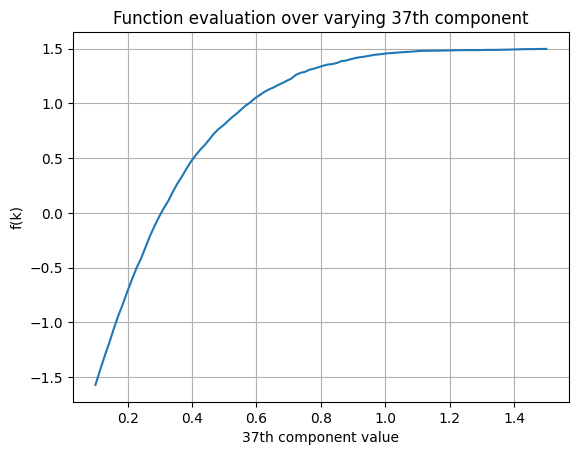

[np.float64(-1.571889929919704),
 np.float64(-1.4392248841590685),
 np.float64(-1.310965831065452),
 np.float64(-1.19175331534883),
 np.float64(-1.0617172227842544),
 np.float64(-0.9414182365281558),
 np.float64(-0.8349246543302931),
 np.float64(-0.7188826927591463),
 np.float64(-0.609469893308876),
 np.float64(-0.5055978148273259),
 np.float64(-0.41838733005443385),
 np.float64(-0.3131353700475126),
 np.float64(-0.20852851858380617),
 np.float64(-0.11780029752877863),
 np.float64(-0.033558866471841586),
 np.float64(0.042068998665926616),
 np.float64(0.11008463916419764),
 np.float64(0.1929473261239425),
 np.float64(0.2686173166596446),
 np.float64(0.33255186886820853),
 np.float64(0.4048661779345706),
 np.float64(0.4696762493226938),
 np.float64(0.5260747109532099),
 np.float64(0.5761917193532261),
 np.float64(0.6193746489983124),
 np.float64(0.670311059304389),
 np.float64(0.7230269957937112),
 np.float64(0.7647127427724475),
 np.float64(0.7967713449853745),
 np.float64(0.83544973694

In [1036]:
def graph_component_37(f, k_original, i, start, stop, num_points=100):
    """
    Function to graph the effect of changing the 37th component of a vector on the output of a function.

    Parameters:
    - f: The function to evaluate.
    - k_original: The original input vector (must be at least 38 elements long).
    - start: The start value for the 37th component.
    - stop: The stop value for the 37th component.
    - num_points: The number of points in the linspace (default is 100).

    Returns:
    - A plot of f(k) as the 37th component of k changes.
    """
    if len(k_original) < i + 1:
        raise ValueError("Input vector must be at least 38 elements long.")
    
    # Generate a linspace for the 37th component
    linspace_values = np.linspace(start, stop, num_points)
    
    # Keep the original vector unchanged for components other than the 37th
    k_fixed = np.copy(k_original)
    
    # Store the results of the function evaluations
    results = []

    # Evaluate the function over the linspace
    for value in linspace_values:
        k_fixed[i] = value  # Update the 37th component (index 36 for 0-based indexing)
        result = f(k_fixed)[i] # Evaluate the function
        results.append(result)

    # Plot the results
    plt.plot(linspace_values, results)
    plt.title("Function evaluation over varying 37th component")
    plt.xlabel("37th component value")
    plt.ylabel("f(k)")
    plt.grid(True)
    plt.show()
    
    return results


graph_component_37(f, k, 45, 0.1, 1.5, num_points=100)